Tim Zhao, B01307256, Feb 16, 2021

In [1]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt

# 
The Debye model of a solid is used to estimate the contribution of atomic vibrations (phonons) to the specific heat capacity. In the Debye model, the specific heat capacity of a solid is given by the following integral expression: 
$C_v/N=9k_B\bigg(\frac{T}{\theta_D}\bigg)\int_{0}^{\theta_D/T} \frac{x^4e^x}{(e^x-1)^2}dx$ 
where $k_B$ is Boltzmann’s constant and θD is the Debye temperature, a property of solids that depends on their density and atomic bonding strength.

a) Write a Python function to calculate $C_V$ for a given material and temperature. Your program should take the density, sample volume, Debye Temperature, temperature upper limit, and required accuracy as inputs, and output the heat capacity between $T = 0$ and the upper temperature limit. Use an adaptive Simpson’s rule to evaluate the integral to the required accuracy.

In [2]:
def adapt_simp(f, start, stop, accuracy, args=None):
    """
    f - function to integrate
    start - lower limit
    stop - upper limit
    accuracy - desired error range
    args - args passed to f, optional
    
    return - (integral, error)
    """
    
    #set initial h and error
    h = 0.01
    error = 100

    #find S0 w/ simpsons
    x_list = np.arange(start,stop+h,h)
    S = (1/3)*(f(start,*args)+f(stop,*args)+2*f(x_list[2:-2:2],*args).sum())
    T = (2/3)* f(x_list[1:-1:2],*args).sum()
    F_current = h*(S+2*T)

    while error > accuracy:
        #update F
        F_last = F_current
       
        #half step size
        h /= 2
        x_list = np.arange(start,stop+h,h)
        
        #adaptive simpson
        S += T
        T = (2/3)* f(x_list[1:-1:2],*args).sum()
        F_current = h*(S+2*T)
        
        #check error
        error = abs((1/15)*(F_current-F_last))
    
    return (F_last, error)

In [3]:
#testing adaptive simpson w/ scipi library.
def debye_integrant(x,):
    g=(x**4*np.exp(x))/(np.exp(x)-1)**2
    return g

np.seterr(all='warn')
start = 0.01
stop = 100
x_list = np.arange(start, stop, 0.01)
f_list = debye_integrant(x_list)
actual = integrate.simpson(f_list, x_list)
print ('scipy', actual)

mine = adapt_simp(debye_integrant, start, stop, 0.000000000001, [])
print('mine', mine)

scipy 25.975757275736758
mine (25.97575727573676, 6.915949294731641e-14)


In [4]:
k_B=1.38 * 10**(-23)
Avogadro = 6.02 * 10**23.


def debye(rho,V,molar_mass,theta_D,T_0,T_max,dT,accuracy):
    """    
    rho - density in g/cm^3
    V - volume in cm^3
    molar_mass - molar mass in amu, to find N
    theta_D - Debye Temperature
    T_0 - Temperature lower limit, must > 0
    T_max - Temperature upper limit
    accuracy - required accuracy
    
    return - array of Heat Capacity between T=0.01 and T_max, with dT=0.01
    """
    #raise runtime warning to error
    np.seterr(all='raise')
    
    #initialize empty lists to store data
    Cv_list=[]
    N=rho*V*Avogadro/molar_mass
    
    #for this particular integral, runtime error occurs when T << 1, and integral upper limit (theta_D/T) >> 1
    #in this case, the result is approx 0. 
    for T in np.arange(T_0,T_max,dT):
        try:
            Cv=9*k_B*(T/theta_D)**3*adapt_simp(debye_integrant, T_0,(theta_D/T), accuracy,[])[0] 
            Cv_list.append(Cv)
        except:
            Cv_list.append(0)
    return Cv_list

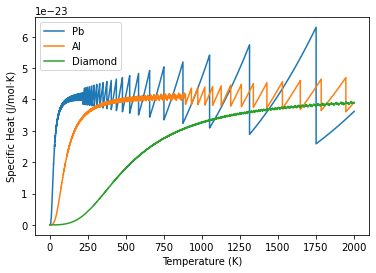

In [5]:
density=1
T_0=0.01
T_max=2000
dT=0.01
T_list=np.arange(T_0,T_max,dT)
accuracy=10**-4

#Lead
Pb_rho=11.35
Pb_molar_mass=207.2
Pb_theta_D=105
Pb_debye=debye(Pb_rho, density, Pb_molar_mass,Pb_theta_D, T_0, T_max,dT, accuracy)
plt.plot(T_list,Pb_debye,label='Pb')

#Aluminum
Al_rho = 2.7
Al_molar_mass = 26.98
Al_theta_D = 428
Al_debye=debye(Al_rho, density, Al_molar_mass, Al_theta_D, T_0,T_max, dT, accuracy)
plt.plot(T_list, Al_debye,label='Al')

#Diamond
dia_rho = 3.51
dia_molar_mass = 12.01
dia_theta_D = 2230
dia_debye=debye(dia_rho, density, dia_molar_mass, dia_theta_D, T_0, T_max,dT,accuracy)
plt.plot(T_list, dia_debye,label='Diamond')

plt.xlabel('Temperature (K)',)
plt.ylabel('Specific Heat (J/mol·K)',)
plt.legend()
plt.show()

Fixed runtime error by running a try - except loop. At low T, integral $\approx 0$.

Cv should approach 25 (dulong petit) as T increases, but I can't figure out where I got the scaling wrong. Moving N to the RHS did not solve the issue.

I think the weird behavior at high T is a result of the small range of integration $\int_{0.01}^{\theta_D/T \ll 1}$. At high T, my adaptive simpson produces similar result as scipy.integrate.quad, but a different result from scipy.integrate.simpson. (See below)

In [6]:
np.seterr(all='warn')
start = 0.01
stop = 105/1500

mine = adapt_simp(debye_integrant, start, stop, 0.000000000001, [])
print('mine      ', mine)

quad=integrate.quad(debye_integrant, start, stop)
print('scipy.quad', quad)

x_list = np.arange(start, stop, 0.01)
f_list = debye_integrant(x_list)
actual = integrate.simpson(f_list, x_list)
print ('scipy.simpson', actual)

mine       (0.00011397198824400376, 4.1608103319828077e-13)
scipy.quad (0.00011397199490129451, 1.2653433290187811e-18)
scipy.simpson 7.182023644126758e-05


In [7]:
#General ODE solver with Runge-Kutta 4
def RK4(f,t_0,t_f,dt,x0, args=None):
    """
    f - a function, takes 2 variables (t,x), RHS of ODE
    t0 - lower limit of independent variable
    t_f - upper limit of independent variable
    dt - step size
    x0 - initial value 
    return - array of t and x
    """
    
    # number of time steps, n must be an integer
    n  = int(np.ceil((t_f-t_0)/dt))
    
    # create empty lists to store values
    x_list=np.zeros(n, np.longdouble)
    t_list=np.linspace(t_0,t_f,n)
    
    # set initial conditions at time zero
    x_list[0] = x0
    t_list[0] = t_0
    
    # RK4
    for ii in range(n-1):
            k1 = dt*f(x_list[ii],t_list[ii],*args)
            k2 = dt*f(x_list[ii]+0.5*k1,t_list[ii]+dt/2,*args)
            k3 = dt*f(x_list[ii]+0.5*k2,t_list[ii]+dt/2,*args)
            k4 = dt*f(x_list[ii]+0.5*k3,t_list[ii]+dt/2,*args)
            
            # update value of Q at each time step and step time by dt
            x_list[ii+1]=x_list[ii]+(k1+2*k2+2*k3+k4)/6
            t_list[ii+1]=t_list[ii]+dt
            
    return t_list, x_list

#
A simple electronic circuit with a resistor and capacitor is shown below.
A voltage is sent into the circuit on the left at $V_{in}$ and read out on the right at $V_{out}$.

a)Find the 1st order ordinary differential equation governing $V_{out}(t)$. Assume the output load impedance is infinite so that no current flows through it. Your equation should relate $dV_{out}/dt$ to $R$, $C$, and $V_{in} − V_{out}$.


$\frac{dQ}{dt}=I=\frac{V_{in}-V_{out}}{R}$

$V_{out}=\frac{Q}{C}$

$\frac{dQ}{dt}=\frac{d}{dt}V_{out}C$

$\frac{d}{dt}V_{out}=\frac{V_{in}-V_{out}}{RC}$

b) Use your RK4 integrator to solve the equation from (a) for a square wave input signal, with frequency 1 and amplitude 1. Make plots of Vout(t) from t = 0 to t = 10 when RC = 0.01, 0.1, and 1, with initial condition Vout(0) = 0. Be careful to select an appropriate time step size for your solution in each case.

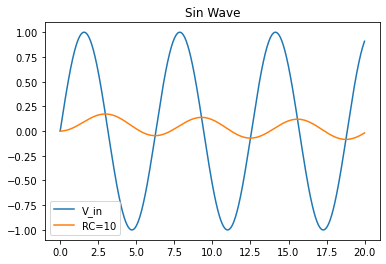

In [8]:
#Testing with sine wave
def sin_signal(V_out, t, RC):
    V_in=np.sin(t)
    return (V_in-V_out)/RC

t=np.arange(0,20,0.01)
x=np.sin(t)
plt.plot(t,x,label='V_in')

T,RC1 = RK4(sin_signal, 0, 20, 0.01, 0,[10])
plt.plot(T,RC1,label='RC=10')

plt.legend()
plt.title('Sin Wave')
plt.show()

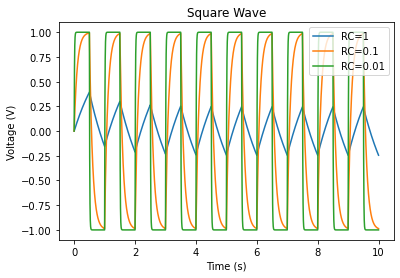

In [9]:
#Square Wave
from scipy import signal

def square_signal(V_out, t, RC):
    #V_in=np.sin(t)
    V_in = signal.square(2 * np.pi * t)
    return (V_in-V_out)/RC

t=np.arange(0,10,0.01)
x=signal.square(2*np.pi*t)
#plt.plot(t,x, label='V_in')    

T,RC1 = RK4(square_signal, 0, 10, 0.001, 0,[1])
plt.plot(T,RC1,label='RC=1')

T,RC01 = RK4(square_signal, 0, 10, 0.001, 0,[0.1])
plt.plot(T,RC01,label='RC=0.1')

T,RC001 = RK4(square_signal, 0, 10, 0.001, 0,[0.01])
plt.plot(T,RC001,label='RC=0.01')

plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend(loc='upper right')
plt.title("Square Wave")
plt.show()

c) Explain physically what the circuit is doing.

$\frac{d}{dt}V_{out}=\frac{V_{in}-V_{out}}{RC}$, the change in $V_{out}$ is proportional to the difference between $V_{in}$ and $V_{out}$. When $V_{in}>V_{out}$, $dV_{out}/dt>0$, $V_{out}$ increases, and vice versa. The proportionality $1/RC$ determines how fast the change is. When RC is small, $V_{out}$ quickly approaches $V_{in}$ until $dV_{out}/dt \approx 0$, and when RC is big, this change is slower.

For this square wave, when $RC=0.01$, $V_{out} \approx V_{in}$. When $RC=1$, $V_{out}$ approaches $V_{in}$ slowly, and $V_{in}$ changes direction before $V_{out}$ gets close to $V_{in}$, creating the sharp triangle $V_{out}$ signal.

If the frequency of $V_{in}$ was lower, a larger $RC$ is needed to filter out $V_{in}$. As shown below, $RC=1$ at 0.1 Hz looks the same as $RC=0.1$ and 1 Hz.

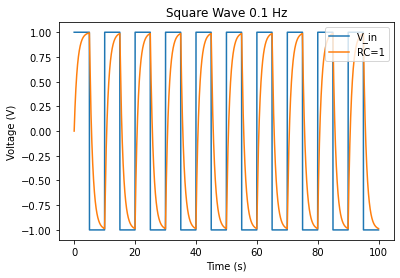

In [10]:
def square_signal(V_out, t, RC):
    #V_in=np.sin(t)
    V_in = signal.square(0.2 * np.pi * t)
    return (V_in-V_out)/RC

t=np.arange(0,100,0.01)
x=signal.square(0.2*np.pi*t)
plt.plot(t,x, label='V_in')    

T,RC1 = RK4(square_signal, 0, 100, 0.01, 0,[1])
plt.plot(T,RC1,label='RC=1')

plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend(loc='upper right')
plt.title("Square Wave 0.1 Hz")
plt.show()

#

Consider a radioactive decay involving two distinct types of nuclei, A and B, with populations NA(t) and NB(t). Suppose that the type A nuclei decay to form type B nuclei which decay in turn according to the differential equations

$\frac{dN_A}{dt}=-\frac{N_A}{\tau_A}$

$\frac{dN_B}{dt}=\frac{N_A}{\tau_A}-\frac{N_B}{\tau_B}$

where τA and τB are the decay time constants for each type of nucleus.

a) Use your RK4 integrator to numerically find the solution of these coupled equations for NA and NB as functions of time.

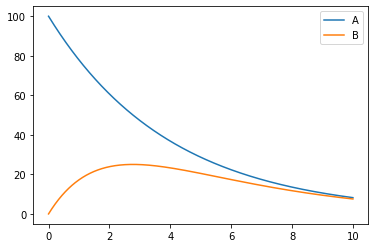

In [11]:
#define the 2 ODEs
def fA(NA,t,tA):
    return -NA/tA

def fB(NB,t,tA,NA,tB):
    return (NA/tA)-(NB/tB)

### SOLVE COUPLED ODE###
def RK4_coupled(fA,fB,tA,tB,t0,t_f,dt):
    #number of time steps, n must be an integer
    n  = int(np.ceil((t_f-t0)/dt)) 

    # create empty lists to store values
    A_list=np.zeros(n, np.longdouble)
    B_list=np.zeros(A_list.size,np.longdouble)
    t_list=np.zeros(A_list.size,np.longdouble)
    
    # set initial conditions at time zero
    A_list[0] = A0
    B_list[0] = B0
    t_list[0] = t0

    # RK4
    for ii in range(n-1): 
    
        #particle A
        A_k1 = dt*fA(A_list[ii],t_list[ii],tA)
        A_k2 = dt*fA(A_list[ii]+0.5*A_k1,t_list[ii]+dt/2,tA)
        A_k3 = dt*fA(A_list[ii]+0.5*A_k2,t_list[ii]+dt/2,tA)     
        A_k4 = dt*fA(A_list[ii]+0.5*A_k3,t_list[ii]+dt/2,tA)
        A_list[ii+1]=A_list[ii]+(A_k1+2*A_k2+2*A_k3+A_k4)/6   

        #particle B 
        B_k1 = dt*fB(B_list[ii],t_list[ii],tA,A_list[ii],tB )
        B_k2 = dt*fB(B_list[ii]+0.5*B_k1,t_list[ii]+dt/2,tA,A_list[ii],tB)
        B_k3 = dt*fB(B_list[ii]+0.5*B_k2,t_list[ii]+dt/2,tA,A_list[ii],tB)     
        B_k4 = dt*fB(B_list[ii]+0.5*B_k3,t_list[ii]+dt/2,tA,A_list[ii],tB)
        B_list[ii+1]=B_list[ii]+(B_k1+2*B_k2+2*B_k3+B_k4)/6

        #update time
        t_list[ii+1]=t_list[ii]+dt
    
    return t_list, A_list, B_list

#set constants and time range
A0=100
B0=0
t0=0
tf=10
dt=0.01

tA=4
tB=2
T,A,B=RK4_coupled(fA,fB,tA,tB,t0,tf,dt)
plt.plot(T,A,label='A')
plt.plot(T,B,label='B')
plt.legend()
plt.show()

b) Find the analytic solution for NA(t) and NB(t) and compare with your numeric results. How accurate is your numeric solution?
see below

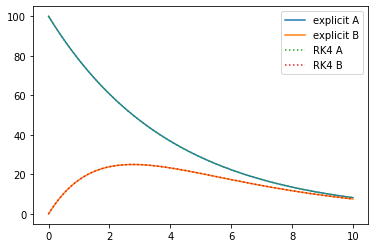

In [12]:
#explicit solution
def NA(t,A0,tA):
    return A0*np.exp(-t/tA)

def NB(t,A0,tA,B0,tB):
    return (A0*tB)/(tA-tB)*np.exp(-t/tA)+(B0+(A0*tB/(tB-tA)))*np.exp(-t/tB)

exp_A =[]
exp_B =[]

for t in T:
    exp_A.append(NA(t, A0, tA))
    exp_B.append(NB(t,A0,tA,B0,tB))

#compare RK4 and explicit solution
plt.plot(T,exp_A,label='explicit A')
plt.plot(T,exp_B, label='explicit B')
plt.plot(T,A,linestyle=':',label='RK4 A')
plt.plot(T,B, linestyle=':',label='RK4 B')
plt.legend()
plt.show()

#a bit hard to see the overlap, but they are essentially the same curve.

c) Explore the behavior for different values of the ratio $\tau_A/\tau_B$ and find the important limits of $\tau_A/\tau_B$.

3 senarios:

i) $\tau_A/\tau_B = 1$

explicit solution is undefined when tA=tB

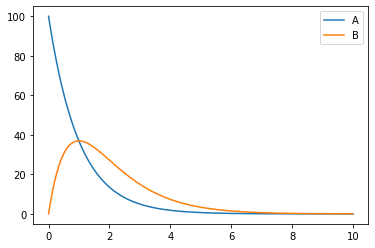

In [13]:
t0=0
tf=10
dt=0.01

#i), tA/tB = 1
tA=1
tB=1
T,A,B=RK4_coupled(fA,fB,tA,tB,t0,tf,dt)
plt.plot(T,A,label='A')
plt.plot(T,B,label='B')
plt.legend()
plt.show()

ii) $\tau_A/\tau_B \gg 1$

when tA>>tB, particle A doesn't decay fast enough for particle B to start decaying

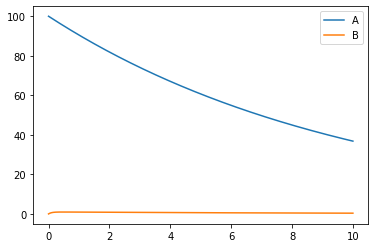

In [14]:
#ii), tA/tB >> 1
tA=10
tB=0.1
T,A,B=RK4_coupled(fA,fB,tA,tB,t0,tf,dt)
plt.plot(T,A,label='A')
plt.plot(T,B,label='B')
plt.legend()
plt.show()

iii) $\tau_A/\tau_B \ll 1$

when tA<<tB, all of particle A quickly decays to particle B, and prticle B gradualy decays.

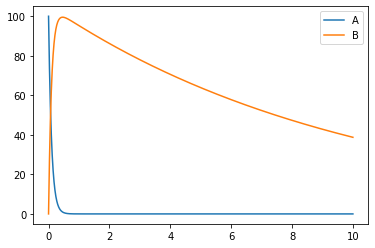

In [15]:
#iii), tA/tB << 1
tA=0.1
tB=10
T,A,B=RK4_coupled(fA,fB,tA,tB,t0,tf,dt)
plt.plot(T,A,label='A')
plt.plot(T,B,label='B')
plt.legend()
plt.show()

4) Provide a physical interpretation the short and long time behaviors for different values of the ratio τA/τB.

The amount of particle B that can decay depends on the rate of decay of particle A. 
When $\tau_A \gg \tau_B$, very few particle A decay to particle B, and the very small amount of particle B quickly decays, so the total number of B is always close to 0.
When $\tau_A \ll \tau_B$, most of particle A quickly decay to particle B, and the amount of particle B increas quickly until A is exhausted, then B gradually decays.

#
In this problem, we will numerically investigate the motion of a baseball. Consider a baseball hit near ground level at a takeoff angle of θ above the horizontal, with an initial speed of v0. Assume there is air resistance that gives a drag force of the form

$F_D=-\frac{1}{2}C_d \rho A \vec{v} \cdot \vec{v} \hat{v}$

where $A$ is the cross-sectional area of the ball, $\rho$ is the density of air, $\vec{v}$ is the velocity of the ball, and $C_d$ is the quadratic drag coefficient. For a baseball $C_d$ is approximately $0.3$, and independent of velocity. The mass of a baseball is $0.15$ kg, and the diameter is $7.4$ cm.

a) Write a program to integrate the equations of motion for the baseball using the RK4 method. The program should take v0 and θ as input. Verify that the program works correctly.

In [5]:
#assuming 2D
def F_drag(vx, vy, C_d=0.3, rho=1.225, A=(0.074/2)**2*np.pi):
    """
    for air resistance
    C_d - quadratic drag coefficient
    A - cross-sectional area
    vx - velocity in x
    vy - velocity in y
    
    return - np array [acc_x, acc_y]
    """
    return (-0.5*C_d*A*rho*np.array([vx,vy])*np.sqrt(vx**2+vy**2))

def acc_x(vx,vy,m=0.15):
    return F_drag(vx,vy)[0]/m

def acc_y(vx,vy,m=0.15):
    return F_drag(vx,vy)[1]/m - 9.8
   
def RK4_baseball(v0, theta, n_bounce, t_0, t_f, dt):
    """
    v0 - initial velocity
    theta - relative to the ground
    n_bounce - how many bounce to graph
    t_0 - initial time
    t_f - final time
    dt - time step
    
    return - np.array of time, x-velocity, y-velocity, x-position, y-position
    """
    
    #initial conditions
    vx_0 = v0*np.cos(theta)
    vy_0 = v0*np.sin(theta) 
    n = int(np.ceil((t_f-t_0)/dt)) 

    # create empty lists and set initial values
    vx=vx_0
    vy=vy_0
    rx=0
    ry=0
    t=t_0
    bounce_counter=0
    
    vx_list=[vx,]
    vy_list=[vy,]
    rx_list=[rx,]
    ry_list=[ry,]
    t_list=[t,]

    # RK4
    for ii in range(n-1):
        
        #stop when baseball hit the ground
        if (ry < 0.0) & (t > 0.0):
            if bounce_counter<n_bounce:
                ry=0
                angle=-np.arctan(vx/vy)
                vx=0.6*np.sqrt(vx**2+vy**2)*np.sin(angle)
                vy=0.6*np.sqrt(vx**2+vy**2)*np.cos(angle)
                bounce_counter+=1
            else:
                break

        #position
        rx+=dt*vx
        ry+=dt*vy
        rx_list.append(rx)
        ry_list.append(ry)

        #x velocity
        vx_k1 = dt*acc_x(vx,vy)
        vx_k2 = dt*acc_x(vx+0.5*vx_k1,vy)
        vx_k3 = dt*acc_x(vx+0.5*vx_k2,vy)
        vx_k4 = dt*acc_x(vx+0.5*vx_k3,vy)
        vx += (vx_k1+2*vx_k2+2*vx_k3+vx_k4)/6
        vx_list.append(vx)

        #y velocity
        vy_k1 = dt*acc_y(vx,vy)
        vy_k2 = dt*acc_y(vx,vy+0.5*vy_k1)
        vy_k3 = dt*acc_y(vx,vy+0.5*vy_k2)
        vy_k4 = dt*acc_y(vx,vy+0.5*vy_k3)
        vy += (vy_k1+2*vy_k2+2*vy_k3+vy_k4)/6
        vy_list.append(vy)

        #time
        t+=dt
        t_list.append(t)
    
    vx_list=np.array(vx_list)
    vy_list=np.array(vy_list)
    rx_list=np.array(rx_list)
    ry_list=np.array(ry_list)
    t_list=np.array(t_list)
    
    return t_list, vx_list, vy_list, rx_list, ry_list

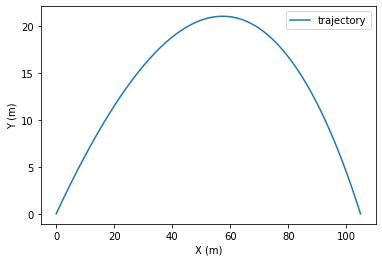

In [6]:
v0=41.667
theta=32
n_bounce=0
t_0=0
t_f=5
dt=0.01

T,Vx,Vy,X,Y=RK4_baseball(v0,theta,n_bounce,t_0,t_f,dt)
plt.plot(X,Y, label='trajectory')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.legend()
plt.show()

b) Plot x−t, y−t, and y−x curves for the baseball with θ = 32◦ and v0 = 150 km/h.

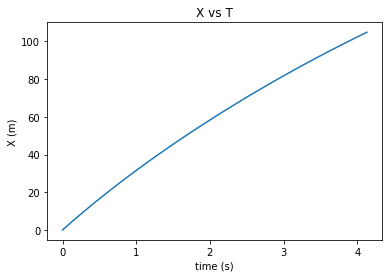

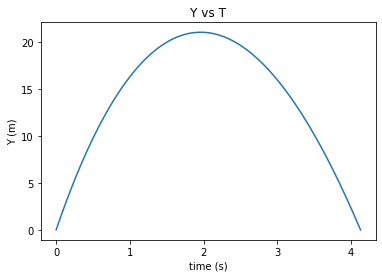

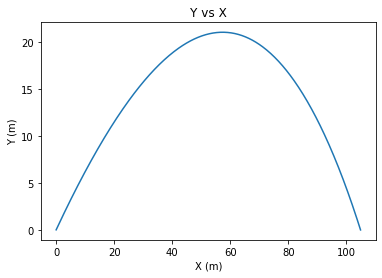

In [7]:
plt.plot(T,X)
plt.xlabel('time (s)')
plt.ylabel('X (m)')
plt.title('X vs T')
plt.show()

plt.plot(T,Y)
plt.xlabel('time (s)')
plt.ylabel('Y (m)')
plt.title('Y vs T')
plt.show()

plt.plot(X,Y)
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Y vs X')
plt.show()

c) Assume that when the baseball hits the ground it bounces with an angle of re- flection equal to the angle of incidence, but with 60% of it’s incident speed. Plot the trajectory of the ball up to the third bounce.

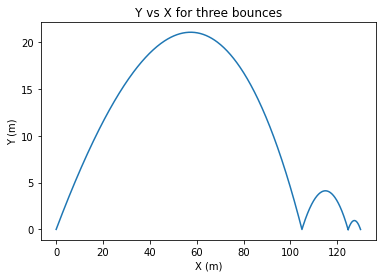

In [8]:
v0=41.667
theta=32
n_bounce=2
t_0=0
t_f=100
dt=0.01

T3,Vx3,Vy3,X3,Y3=RK4_baseball(v0, theta,n_bounce,t_0,t_f,dt)
plt.plot(X3,Y3,label='trajectory')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Y vs X for three bounces')
plt.show()

e) Track the work done by the drag force on the ball up until the first time it hits the ground. Verify that the work-energy theorem is satisfied by testing the relation $W_{drag} \approx E − E_0$, where

$W_{drag} = \int \vec{F}_{drag} \cdot d\vec{r} \approx \sum \vec{F}_{drag} \cdot d\vec{r}$

is the work done up to time $t$. $E_0$ is the initial energy and $E$ the total energy at time $t$. Plot $E$, $W_{drag}$, and $E − W_{drag}$ as a function of time. Energy conservation is a condition that may be used to validate your program and choice of step size.

dt =  1e-05
E_f-E_0 =  -77.70327744460164
W_drag  =  -77.70337208471778


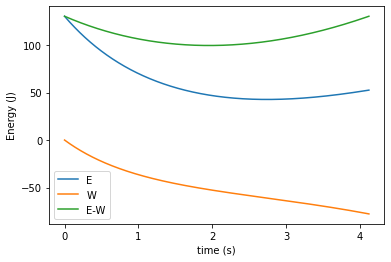

In [23]:
v0=41.667
theta=32
n_bounce=0
t_0=0
t_f=5
dt=0.00001
m=0.15

T,Vx,Vy,X,Y=RK4_baseball(v0,theta,n_bounce,t_0,t_f,dt)

#Initialization
E_0=0.5*m*v0**2
E_list=[E_0,]

W=0
W_list=[W,]

for j in range(len(T)-1):
    E=0.5*m*(Vx[j]**2+Vy[j]**2)
    E_list.append(E)
    W+=F_drag(Vx[j+1],Vy[j+1])[0]*(X[j+1]-X[j])+F_drag(Vx[j+1],Vy[j+1])[1]*(Y[j+1]-Y[j])
    W_list.append(W)
    
E=np.array(E_list)
W=np.array(W_list)
A=E-W

print('dt = ', dt)
print('E_f-E_0 = ', E_list[-1]-E_list[0])
print('W_drag  = ', W_list[-1])

plt.plot(T,E_list, label='E')
plt.plot(T,W_list, label='W')
plt.plot(T,A, label = 'E-W')
plt.xlabel('time (s)')
plt.ylabel('Energy (J)')
plt.legend()
plt.show()